In [1]:
import jcopdl
jcopdl.__version__

'1.1.10'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataset and Dataloader

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import MultilabelDataset

In [5]:
bs = 64
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = MultilabelDataset("data/train_label.csv", "data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = MultilabelDataset("data/test_label.csv", "data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [6]:
label2cat = train_set.classes
label2cat

['desert', 'mountains', 'sea', 'sunset', 'trees']

# Arsitektur dan Config 

### Contoh cara pakai pre-trained model

In [7]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

In [8]:
mnet = mobilenet_v2(weights=MobileNet_V2_Weights)

C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
for param in mnet.parameters():
    param.requires_grad = False

In [15]:
mnet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [16]:
mnet.classifier = nn.Sequential(
    nn.Linear(1280, 5),
    nn.Sigmoid()
)

In [17]:
mnet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [9]:
class CustomMobilenetV2(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.mnet = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Linear(1280, output_size),
            nn.Sigmoid()
        )
        
        
    def forward(self, x):
        return self.mnet(x)
    
    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False
    
    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True

In [10]:
config = set_config({
    "output_size": len(train_set.classes),
    "batch_size": bs,
    "crop_size": crop_size
})

## Phase 1: Adaptation (lr standard + patience kecil)

In [11]:
model = CustomMobilenetV2(config.output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir="model")

In [12]:
from tqdm import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Test: 100%|██████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.12it/s]



Epoch     1
Train_cost  = 0.5311 | Test_cost  = 0.4461 | 


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.34it/s]



Epoch     2
Train_cost  = 0.4080 | Test_cost  = 0.3725 | 


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.46it/s]



Epoch     3
Train_cost  = 0.3527 | Test_cost  = 0.3341 | 


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.40it/s]



Epoch     4
Train_cost  = 0.3166 | Test_cost  = 0.3097 | 


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.40it/s]



Epoch     5
Train_cost  = 0.2959 | Test_cost  = 0.2891 | 


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.37it/s]



Epoch     6
Train_cost  = 0.2766 | Test_cost  = 0.2726 | 


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.42it/s]



Epoch     7
Train_cost  = 0.2706 | Test_cost  = 0.2658 | 


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.32it/s]



Epoch     8
Train_cost  = 0.2583 | Test_cost  = 0.2546 | 


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.48it/s]



Epoch     9
Train_cost  = 0.2496 | Test_cost  = 0.2510 | 


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.41it/s]



Epoch    10
Train_cost  = 0.2429 | Test_cost  = 0.2471 | 


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.43it/s]



Epoch    11
Train_cost  = 0.2373 | Test_cost  = 0.2382 | 


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.25it/s]



Epoch    12
Train_cost  = 0.2340 | Test_cost  = 0.2424 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2382


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.53it/s]



Epoch    13
Train_cost  = 0.2353 | Test_cost  = 0.2332 | 


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.46it/s]



Epoch    14
Train_cost  = 0.2266 | Test_cost  = 0.2297 | 


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.32it/s]



Epoch    15
Train_cost  = 0.2222 | Test_cost  = 0.2286 | 


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.40it/s]



Epoch    16
Train_cost  = 0.2182 | Test_cost  = 0.2240 | 


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.28it/s]



Epoch    17
Train_cost  = 0.2144 | Test_cost  = 0.2200 | 


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.42it/s]



Epoch    18
Train_cost  = 0.2136 | Test_cost  = 0.2181 | 


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.37it/s]



Epoch    19
Train_cost  = 0.2087 | Test_cost  = 0.2193 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2181


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.43it/s]



Epoch    20
Train_cost  = 0.2033 | Test_cost  = 0.2141 | 


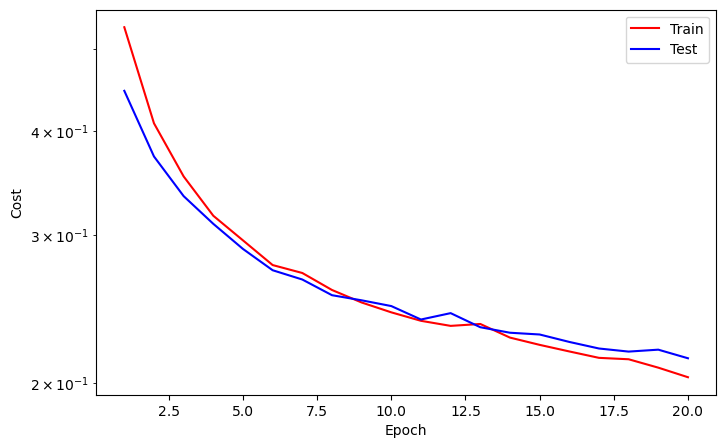

Test: 100%|██████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.35it/s]



Epoch    21
Train_cost  = 0.2064 | Test_cost  = 0.2225 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2141


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.40it/s]



Epoch    22
Train_cost  = 0.1996 | Test_cost  = 0.2165 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2141
==> Execute Early Stopping at epoch: 22 | Best test_cost: 0.2141
==> Best model is saved at model


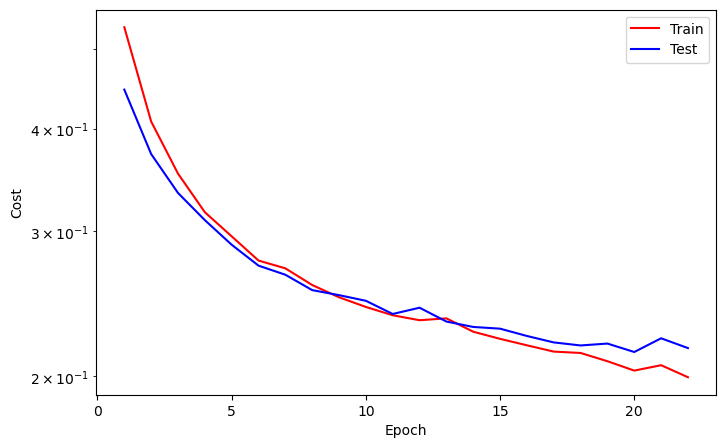

In [13]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Phase 2: Fine-tuning (lower lr + more patience)

In [16]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 5

In [17]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

Train:   0%|                                                                                    | 0/26 [00:09<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 38.00 MiB. GPU 

# Predict

In [33]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [34]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = (output > 0.5).to(torch.float32)

In [27]:
preds

tensor([[0., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 0.],
        [1., 0., 1., 1., 1.],
        [0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 1.],
        [1., 1., 1., 1., 1.],
        [0., 0., 1., 0., 0.],
        [1., 1., 1., 1., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.],
        [0., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0.],
        [0., 1., 0., 1., 1.],
        [0., 1., 0., 0., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1.],
        [0., 0., 1., 0., 1.],
        [0., 1., 1., 1., 1.],
        [0., 1., 1., 0., 1.],
        [0

# Sanity Check

In [28]:
def convert_to_label(x):
    return [label for pred, label in zip(x, label2cat) if pred==1]

def inverse_norm(img):
    img[0, :, :] = img[0, :, :] * 0.229 + 0.485
    img[1, :, :] = img[1, :, :] * 0.224 + 0.456
    img[2, :, :] = img[2, :, :] * 0.225 + 0.406
    return img

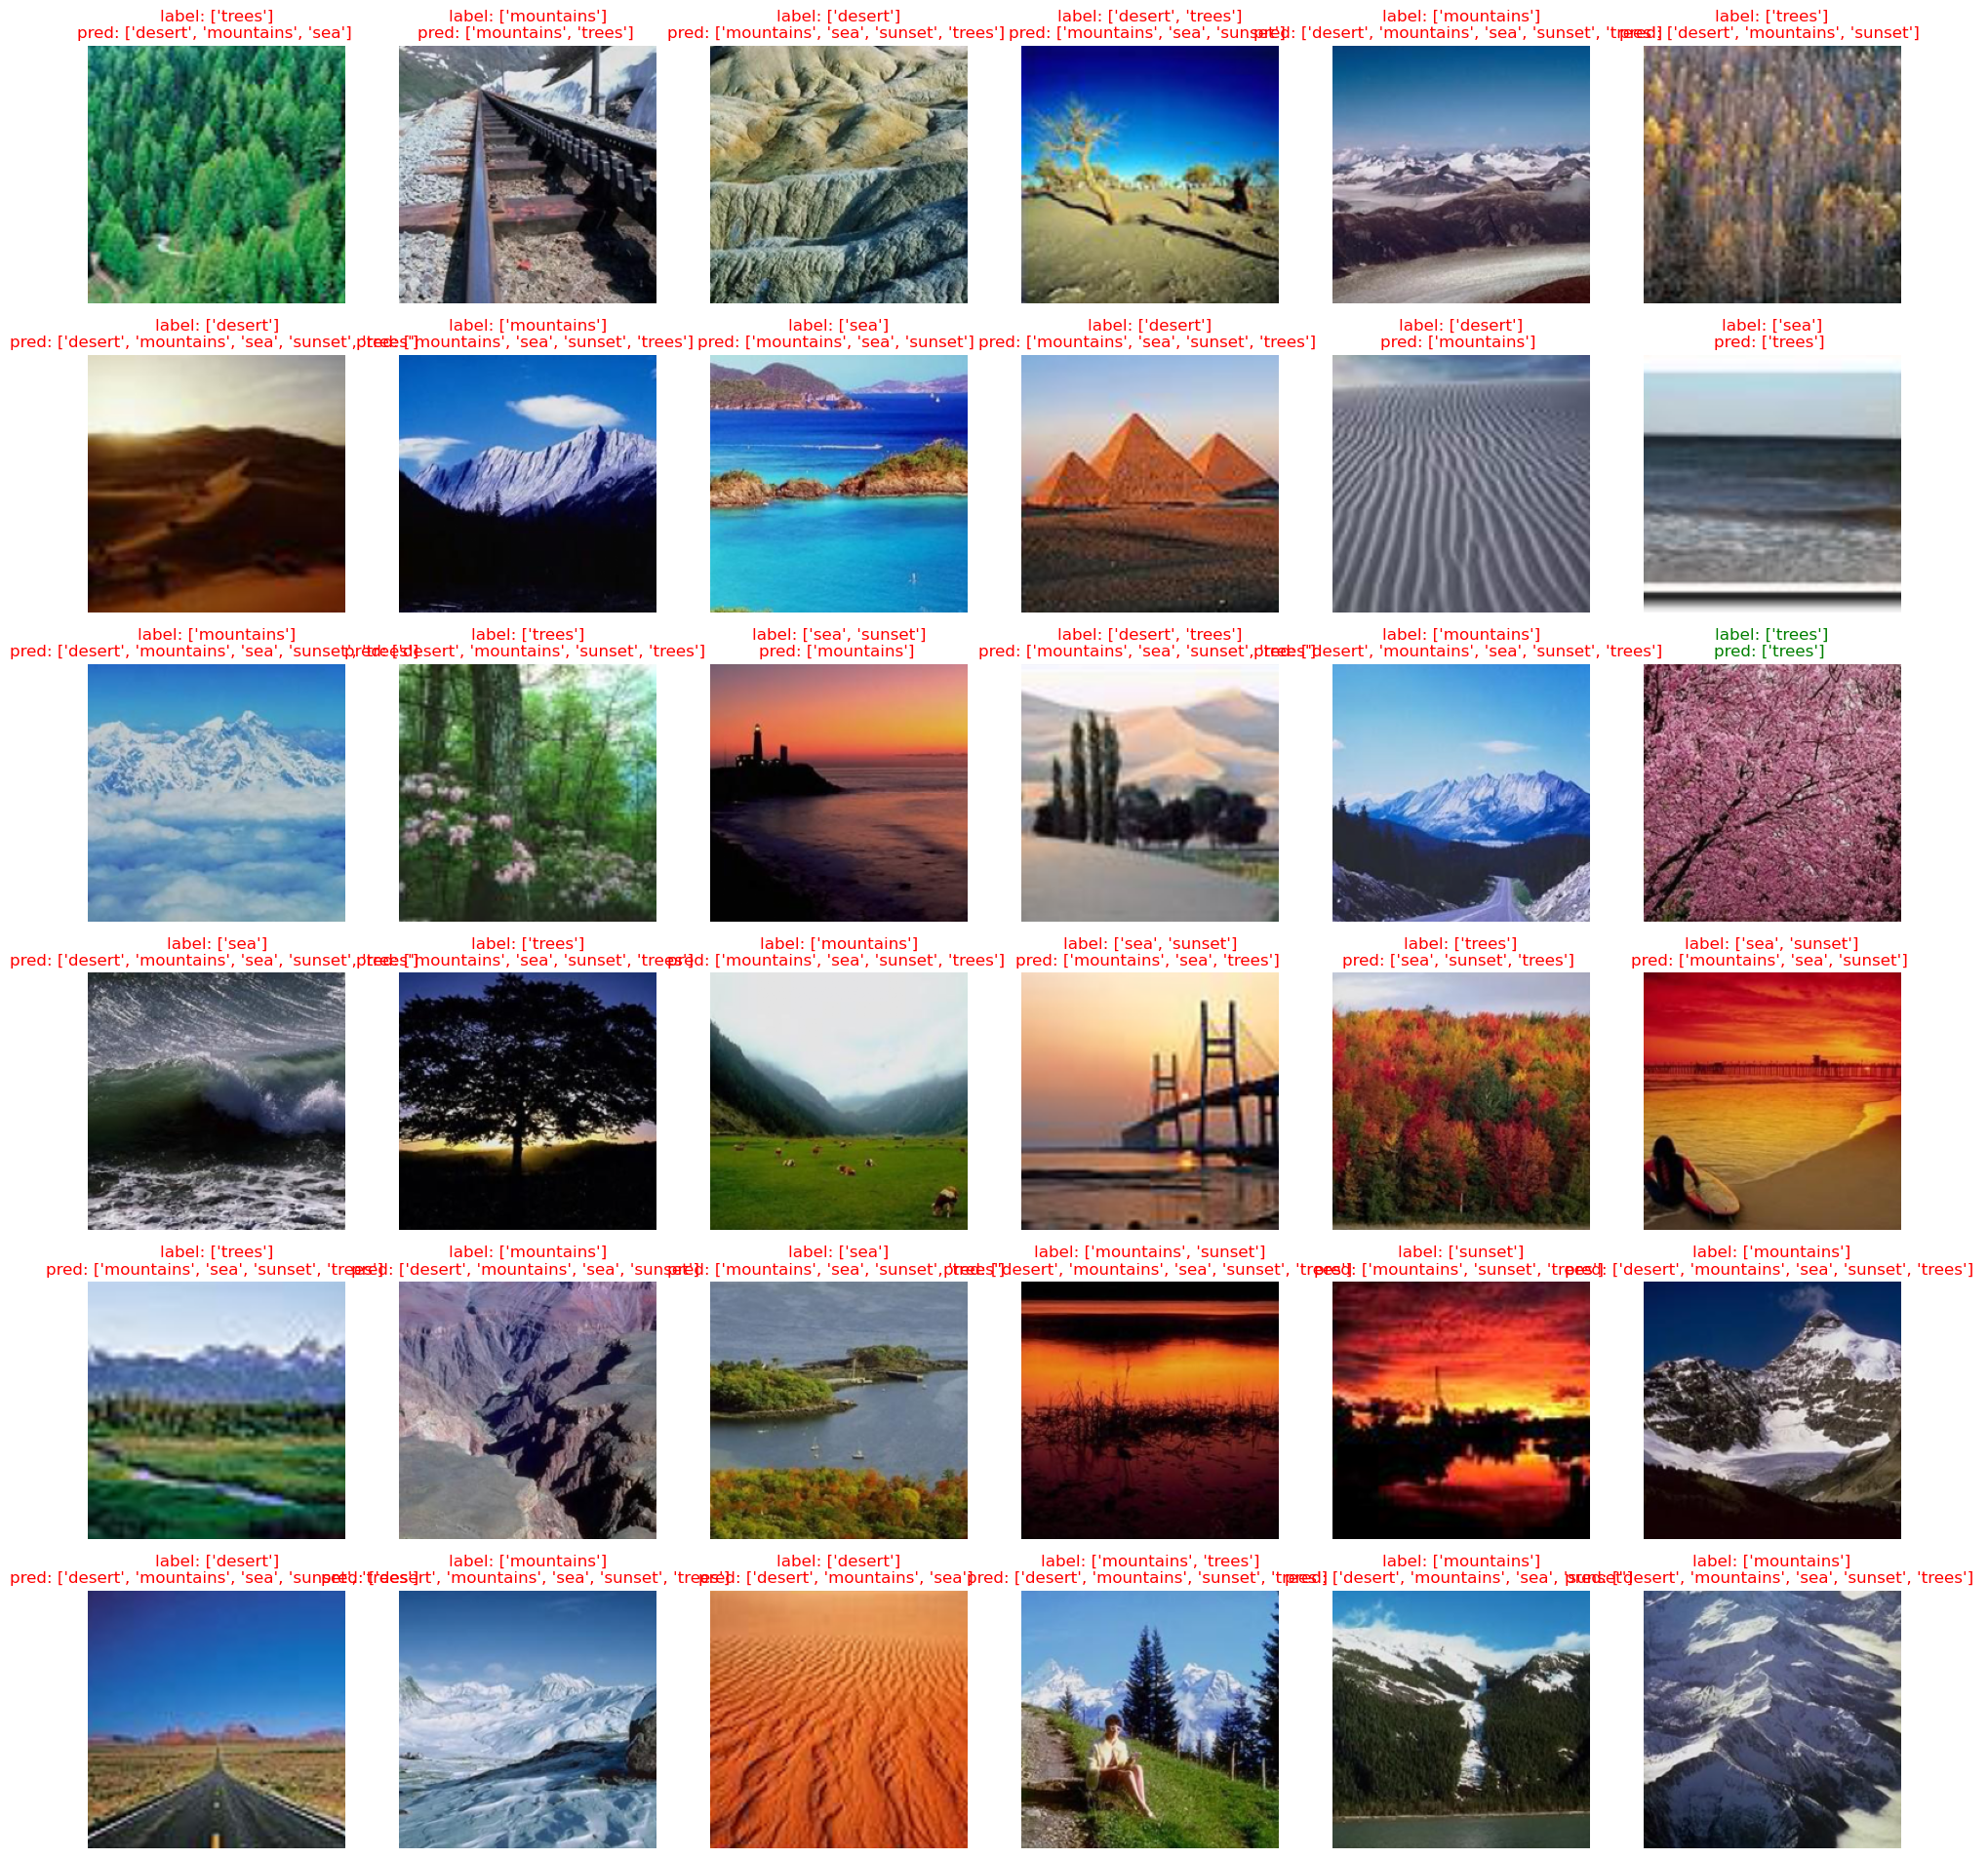

In [35]:
fig, axes = plt.subplots(6, 6, figsize=(24,24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1, 2, 0).cpu())
    font = {"color": 'r'} if (pred != label).any() else {"color": 'g'}
    label, pred = convert_to_label(label), convert_to_label(pred)
    ax.set_title(f"label: {label}\npred: {pred} ", fontdict=font);
    ax.axis('off');